In [3]:
# utilities
import re
import numpy as np
import pandas as pd
# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# nltk
from nltk.stem import WordNetLemmatizer
import nltk
from textblob import TextBlob
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

After importing packages, load the tweets scraped previously.

In [4]:
df = pd.read_csv("tweets.csv")

Next, we need to preprocess tweets. This means we should tokenize them and clean them with regular expressions. We do so by creating a function and running that function on all of the tweets that we have collected.

In [5]:
def tokenize_tweets(text_series):
    '''
    Cleans + tokenizes Pandas series of strings from the Salem Witch dataset.
    
    Returns pandas series of lists of tokens
    '''
    tweet_regex = "[^a-z\s]"
    clean = text_series.str.lower() \
                       .str.replace(tweet_regex,
                                    " ",
                                    regex=True)

    stop = nltk.corpus.stopwords.words('english')

    tokenize = lambda text: [i for i in nltk.word_tokenize(text) if i not in stop]
    tokens = clean.apply(tokenize)
    return tokens

In [6]:
df['tokens'] = tokenize_tweets(df['tweet'])

In [7]:
df.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,tokens
0,1442277789164466176,1442277789164466176,2021-09-26 18:59:55 CDT,2021-09-26,18:59:55,-500,25843801,lau56,"Larry Underwood: ""Taking A Stand Against Trump...",NaN,...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"[anti, vaxx, chronicles, smuggling, ivermectin..."
1,1442277711242678275,1441081536019767296,2021-09-26 18:59:37 CDT,2021-09-26,18:59:37,-500,1067245130,bigl62,LV,NaN,...,NaN,NaN,NaN,NaN,"[{'screen_name': 'sadlybradleytoo', 'name': 'G...",NaN,NaN,NaN,NaN,"[talkingttweets, sadlybradleytoo, davidstaples..."
2,1442277511208001536,1442277511208001536,2021-09-26 18:58:49 CDT,2021-09-26,18:58:49,-500,1250279783717429248,mariannedouce14,Marianne Doucette,NaN,...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"[explosive, india, state, million, people, dec..."
3,1442277465829691397,1442229048143273988,2021-09-26 18:58:38 CDT,2021-09-26,18:58:38,-500,1265033840,caz_sampson,Caz Sampson,NaN,...,NaN,NaN,NaN,NaN,"[{'screen_name': 'GeordiLaforgei', 'name': 'Ge...",NaN,NaN,NaN,NaN,"[geordilaforgei, docjohng, pierrekory, really,..."
4,1442277212955291652,1442277212955291652,2021-09-26 18:57:38 CDT,2021-09-26,18:57:38,-500,4114756575,traumagotchiv2,marcelle,NaN,...,NaN,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,"[alberta, editable, immunization, pdf, stupid,..."


In [8]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'tokens'],
      dtype='object')

We can then subset down to the information pertinent to our analysis, which is the date of the tweet, the content of the tweet itself, and the tokens we created previously.

In [9]:
df_small = df[['date', 'tweet', 'tokens']]

In [10]:
df_small.head()

,date,tweet,tokens
0,2021-09-26,Anti-vaxx Chronicles: Smuggling ivermectin int...,"[anti, vaxx, chronicles, smuggling, ivermectin..."
1,2021-09-26,@talkingttweets @sadlybradleytoo @DavidStaples...,"[talkingttweets, sadlybradleytoo, davidstaples..."
2,2021-09-26,Explosive! India State of 241 MILLION People D...,"[explosive, india, state, million, people, dec..."
3,2021-09-26,@GeordiLaforgei @DocJohnG @PierreKory Really i...,"[geordilaforgei, docjohng, pierrekory, really,..."
4,2021-09-26,"""alberta editable immunization pdf"" - a stupid...","[alberta, editable, immunization, pdf, stupid,..."


We can then run a sentiment analysis function using TextBlob's built-in classification functionality.

In [11]:
def get_tweet_sentiment(self, tweet):
    '''
    Utility function to classify sentiment of passed tweet
    using textblob's sentiment method
    '''
    # create TextBlob object of passed tweet text
    analysis = TextBlob(self.clean_tweet(tweet))
    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

In [12]:
def senti(x):
    return TextBlob(x).sentiment.polarity  

df_small['senti_score'] = df_small['tweet'].apply(senti)

/var/folders/_f/cn7w2_g979z63x69nw9b3y_r0000gn/T/ipykernel_53692/2262727498.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['senti_score'] = df_small['tweet'].apply(senti)


In [13]:
df_small.head()

,date,tweet,tokens,senti_score
0,2021-09-26,Anti-vaxx Chronicles: Smuggling ivermectin int...,"[anti, vaxx, chronicles, smuggling, ivermectin...",0.35
1,2021-09-26,@talkingttweets @sadlybradleytoo @DavidStaples...,"[talkingttweets, sadlybradleytoo, davidstaples...",0.05
2,2021-09-26,Explosive! India State of 241 MILLION People D...,"[explosive, india, state, million, people, dec...",0.00
3,2021-09-26,@GeordiLaforgei @DocJohnG @PierreKory Really i...,"[geordilaforgei, docjohng, pierrekory, really,...",0.08
4,2021-09-26,"""alberta editable immunization pdf"" - a stupid...","[alberta, editable, immunization, pdf, stupid,...",-0.65


In [14]:
df_grouped = df_small.groupby('date').mean()

We can then plot the mean of the average sentiment score.

Text(0, 0.5, 'Average Sentiment Score')

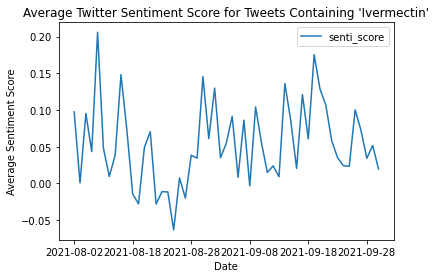

In [15]:
ax = df_grouped.plot(use_index=True, title="Average Twitter Sentiment Score for Tweets Containing 'Ivermectin'")
ax.set_xlabel("Date")
ax.set_ylabel("Average Sentiment Score")

In [16]:
df_2 = df_small.groupby('date').size()

We can also plot the number of tweets containing ivermectin per day. Please note, these graphs were created using the small subset of tweets in tweets.csv. See the README or paper for the official graphs and statistics.

Text(0, 0.5, 'Number of Tweets')

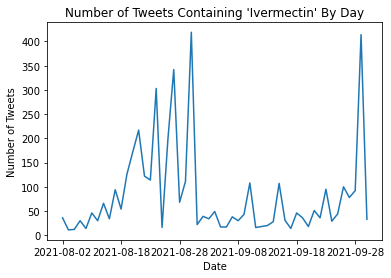

In [17]:
ax2 = df_2.plot(title="Number of Tweets Containing 'Ivermectin' By Day")
ax2.set_xlabel("Date")
ax2.set_ylabel("Number of Tweets")

In [18]:
df.columns

Index(['id', 'conversation_id', 'created_at', 'date', 'time', 'timezone',
       'user_id', 'username', 'name', 'place', 'tweet', 'language', 'mentions',
       'urls', 'photos', 'replies_count', 'retweets_count', 'likes_count',
       'hashtags', 'cashtags', 'link', 'retweet', 'quote_url', 'video',
       'thumbnail', 'near', 'geo', 'source', 'user_rt_id', 'user_rt',
       'retweet_id', 'reply_to', 'retweet_date', 'translate', 'trans_src',
       'trans_dest', 'tokens'],
      dtype='object')

In [19]:
df_small

,date,tweet,tokens,senti_score
0,2021-09-26,Anti-vaxx Chronicles: Smuggling ivermectin int...,"[anti, vaxx, chronicles, smuggling, ivermectin...",0.350000
1,2021-09-26,@talkingttweets @sadlybradleytoo @DavidStaples...,"[talkingttweets, sadlybradleytoo, davidstaples...",0.050000
2,2021-09-26,Explosive! India State of 241 MILLION People D...,"[explosive, india, state, million, people, dec...",0.000000
3,2021-09-26,@GeordiLaforgei @DocJohnG @PierreKory Really i...,"[geordilaforgei, docjohng, pierrekory, really,...",0.080000
4,2021-09-26,"""alberta editable immunization pdf"" - a stupid...","[alberta, editable, immunization, pdf, stupid,...",-0.650000
...,...,...,...,...
4333,2021-09-28,@JustSomeLady_ It's kinda serious times. Scary...,"[justsomelady, kinda, serious, times, scary, t...",-0.077778
4334,2021-09-28,@msjessienz This is the official clinical mana...,"[msjessienz, official, clinical, management, p...",0.000000
4335,2021-09-28,And here we see why the Ivermectin nonsense is...,"[see, ivermectin, nonsense, getting, pushed, b...",-0.250000
4336,2021-09-28,"@MollyJongFast ""The demand has strained the eq...","[mollyjongfast, demand, strained, equine, amp,...",0.000000


In [28]:
df_small[(df_small['date'] > '2021-08-24') & (df_small['date'] < '2021-08-26')]

,date,tweet,tokens,senti_score
3462,2021-08-25,@thedailybeast Ivermectin is most dangerous to...,"[thedailybeast, ivermectin, dangerous, bottom,...",-0.050000
3463,2021-08-25,@_pseudo_name I'm an old farm girl. Ivermecti...,"[pseudo, name, old, farm, girl, ivermectin, ap...",0.157143
3464,2021-08-25,Would it be in bad taste to set up a pop-up sh...,"[would, bad, taste, set, pop, shop, selling, i...",-0.350000
3465,2021-08-25,There is an FDA approved human #Ivermectin It...,"[fda, approved, human, ivermectin, never, safe...",-0.062500
3466,2021-08-25,@ifyoutoleratet2 #Ivermectin,"[ifyoutoleratet, ivermectin]",0.000000
3467,2021-08-25,@ryanlcooper The really frustrating thing is t...,"[ryanlcooper, really, frustrating, thing, unde...",-0.362500
3468,2021-08-25,Review of the Emerging Evidence Demonstrating ...,"[review, emerging, evidence, demonstrating, ef...",0.000000
3469,2021-08-25,@ebruenig Acting as though Ivermectin isn't pr...,"[ebruenig, acting, though, ivermectin, prescri...",-0.250000
3470,2021-08-25,@unhappytwituser @arlene8022 @thedailybeast It...,"[unhappytwituser, arlene, thedailybeast, free,...",0.160000
3471,2021-08-25,"@AssBoss80085 ""i had a straw of bull semen del...","[assboss, straw, bull, semen, delivered, gon, ...",-0.111111
